# Converter that converts yolo annotation file to passcal voc

In [14]:
import os
import re
from PIL import Image

# folder_holding_yolo_files = input("Enter the path to the yolo files: ").replace("'", "").strip()
# yolo_class_list_file = input("Enter the path to the file that has the yolo classes (typically classes.txt): ").strip()

folder_holding_yolo_files=r'/home/lu/Desktop/will/jupyter/thermal/train_1842/'
yolo_class_list_file = r'/home/lu/Desktop/will/jupyter/thermal/train_1842/_darknet.labels'

# Get a list of all the classes used in the yolo format
with open(yolo_class_list_file) as f:
    yolo_classes = f.readlines()
array_of_yolo_classes = [x.strip() for x in yolo_classes]

# Description of Yolo Format values
# 15 0.448743 0.529142 0.051587 0.021081
# class_number x_yolo y_yolo yolo_width yolo_height

def is_number(n):
  try:
    float(n)
    return True
  except ValueError:
    return False

os.chdir(folder_holding_yolo_files)

if not os.path.exists(folder_holding_yolo_files + os.sep + 'XML'):
  # If an XML folder does not already exist, make one
  os.mkdir('XML')

for each_yolo_file in os.listdir(folder_holding_yolo_files):
  if '._' in each_yolo_file:
    continue
  if each_yolo_file.endswith("txt"):
    with open(each_yolo_file, 'r', errors='replace') as the_file:
      all_lines = the_file.readlines()
    image_name = each_yolo_file

    # Check to see if there is an image that matches the txt file
    if os.path.exists(each_yolo_file.replace('txt', 'jpeg')):
      image_name = each_yolo_file.replace('txt', 'jpeg')
    if os.path.exists(each_yolo_file.replace('txt', 'jpg')):
      image_name = each_yolo_file.replace('txt', 'jpg')
    if os.path.exists(each_yolo_file.replace('txt', 'png')):
      image_name = each_yolo_file.replace('txt', 'png')

    if not image_name == each_yolo_file:
      # If the image name is the same as the yolo filename
      # then we did NOT find an image that matches, and we will skip this code block
      orig_img = Image.open(image_name) # open the image
      image_width = orig_img.width
      image_height = orig_img.height

      # Start the XML file
      with open('XML' + os.sep + each_yolo_file.replace('txt', 'xml'), 'w') as f:
        f.write('<annotation>\n')
        f.write('\t<folder>XML</folder>\n')
        f.write('\t<filename>' + image_name + '</filename>\n')
        f.write('\t<path>' + os.getcwd() + os.sep + image_name + '</path>\n')
        f.write('\t<source>\n')
        f.write('\t\t<database>Unknown</database>\n')
        f.write('\t</source>\n')
        f.write('\t<size>\n')
        f.write('\t\t<width>' + str(image_width) + '</width>\n')
        f.write('\t\t<height>' + str(image_height) + '</height>\n')
        f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
        f.write('\t</size>\n')
        f.write('\t<segmented>0</segmented>\n')
      
        for each_line in all_lines:
          # regex to find the numbers in each line of the text file
          yolo_array = re.split("\s", each_line.rstrip()) # remove any extra space from the end of the line

          # initalize the variables
          class_number = 0
          x_yolo = 0.0
          y_yolo = 0.0
          yolo_width = 0.0
          yolo_height = 0.0
          yolo_array_contains_only_digits = True

          # make sure the array has the correct number of items
          if len(yolo_array) == 5:
            for each_value in yolo_array:
              # If a value is not a number, then the format is not correct, return false
              if not is_number(each_value):
                yolo_array_contains_only_digits = False
            
            if yolo_array_contains_only_digits:
              # assign the variables
              class_number = int(yolo_array[0])
              object_name = array_of_yolo_classes[class_number]
              x_yolo = float(yolo_array[1])
              y_yolo = float(yolo_array[2])
              yolo_width = float(yolo_array[3])
              yolo_height = float(yolo_array[4])

              # Convert Yolo Format to Pascal VOC format
              box_width = yolo_width * image_width
              box_height = yolo_height * image_height
              x_min = str(int(x_yolo * image_width - (box_width / 2)))
              y_min = str(int(y_yolo * image_height - (box_height / 2)))
              x_max = str(int(x_yolo * image_width + (box_width / 2)))
              y_max = str(int(y_yolo * image_height + (box_height / 2)))

              # write each object to the file
              f.write('\t<object>\n')
              f.write('\t\t<name>' + object_name + '</name>\n')
              f.write('\t\t<pose>Unspecified</pose>\n')
              f.write('\t\t<truncated>0</truncated>\n')
              f.write('\t\t<difficult>0</difficult>\n')
              f.write('\t\t<bndbox>\n')
              f.write('\t\t\t<xmin>' + x_min + '</xmin>\n')
              f.write('\t\t\t<ymin>' + y_min + '</ymin>\n')
              f.write('\t\t\t<xmax>' + x_max + '</xmax>\n')
              f.write('\t\t\t<ymax>' + y_max + '</ymax>\n')
              f.write('\t\t</bndbox>\n')
              f.write('\t</object>\n')

        # Close the annotation tag once all the objects have been written to the file
        f.write('</annotation>\n')
        f.close() # Close the file

# Check to make sure the sprite file is now in the folder
if os.path.exists("XML"):
  print("Conversion complete")
else:
  print("There was a problem converting the files")

Conversion complete


In [2]:
!ls -lR thermal/train_1842/XML/*.xml | wc -l

1474


# Install required dependency

In [ ]:
# sudo apt -y install libportaudio2
!pip install tflite-support
!pip install tflite-model-maker

# if using different python environment apt install python3.*-dev first
!pip install pycocotools

In [ ]:
!pip list | grep tflite

!pip list | grep pycocotools

tflite-model-maker            0.4.2         /home/lu/Desktop/will/jupyter/examples/tensorflow_examples/lite/model_maker/pip_package/src
tflite-support                0.4.3


# 1. Prepare Dataset images in JPEG

In [3]:
import os,shutil

# target_dir = r"tflite_data/trainingObj/train"
target_dir = r"thermal/train_1842/"

# print all files under target_dir path
# for root,dirs,files in os.walk(target_dir):
#   for filename in files:
#     print(filename)

for each_file in os.listdir(target_dir):
  if '._' in each_file:
    continue
  print(each_file)

FLIR_08787_jpeg.rf.eabea7f215634caeb359ab69fb991f00.jpg
FLIR_07646_jpeg.rf.f839fe77eb7a9315124d6f23c1b5417b.jpg
FLIR_07933_jpeg.rf.254e2586b679bcf592686facf1fd910e.txt
FLIR_08465_jpeg.rf.6585d99e23a37a18cb7139d07cef1091.txt
FLIR_07707_jpeg.rf.b6f58188438b44db8562d23361a7fee4.txt
FLIR_07531_jpeg.rf.c1ce0c419f26a0ea36fc23443b77d02f.jpg
FLIR_07115_jpeg.rf.3949a8f37a3dc3cea1cc199629046779.jpg
FLIR_07755_jpeg.rf.3abe733c54a50ed27998d223e4c4e2c4.jpg
FLIR_07207_jpeg.rf.bdc56aae8f87cf54a7ce1b475a92aacf.jpg
FLIR_07702_jpeg.rf.de9d2f94c5376dff95e53cfc5c1e601c.jpg
FLIR_07727_jpeg.rf.8049b7f69ecc76d08005566f821df94d.jpg
FLIR_08416_jpeg.rf.ab31b49af71b2c5e78b9c89cc0f18301.txt
FLIR_07893_jpeg.rf.84ffcdb64bfe19af404db8a72f77e439.jpg
FLIR_08052_jpeg.rf.b0ff31815973174770950d66de19c4a4.jpg
FLIR_08788_jpeg.rf.2c9ccd91e3712dabf9c9e9ab8eb5b8f5.jpg
FLIR_08696_jpeg.rf.78db150c6a12cc018db47afa0b860ed3.txt
FLIR_07995_jpeg.rf.11355f90fedfa12579d4050fd2cfb2d4.jpg
FLIR_07468_jpeg.rf.6bbfe768d518a4317ac654a57f902

In [ ]:
# shuffle files
# from random import shuffle
# from glob import glob
# files = glob(r"tflite_data/trainingObj/converted/train/*.jpg")
# shuffle(files)

# for file in files:
  # ...

### Split 0.8,0.1,0.1, train images, validate images, test images

In [44]:
import os,shutil,re

val_dir = r'thermal/val_1842/'
test_dir = r'thermal/test_1842/'
train_dir = r'thermal/train_1842/'

# toogle the movdir,and targetDir to meet your expectations
mov_dir = val_dir
target_dir = test_dir

# move .jpg and .xml from movdir to targetDir
for root,dirs,files in os.walk(mov_dir):
  i = 0
  count = 0
  for filename in files:
    if '._' in filename:
      continue
    #extract file base name
    base,extension = os.path.splitext(filename)
    if(extension != ".jpg"):
      continue

    xml_filename=base+".xml"
    old_name = os.path.join(os.path.abspath(root),filename)
    old_name_xml = os.path.join(os.path.abspath(root),xml_filename)
    # 2/10 images with extension ".jpg" is move to target folder
    if(i != 0 and extension == ".jpg" and i%2 == 0):
      new_name_jpg = os.path.join(target_dir,filename)
      new_name_xml = os.path.join(target_dir,xml_filename)

      # print(count, new_name_xml)
      
      # move file to validate
      if not (
        os.path.exists(os.path.join(target_dir)) and 
        os.path.exists(os.path.join(mov_dir))         
      ):
        print(os.path.join(target_dir),"or ",os.path.join(mov_dir)," not found")
        continue

      elif not (
          os.path.exists(new_name_jpg) or
          os.path.exists(new_name_xml)
      ):
        shutil.move(old_name,new_name_jpg)
        shutil.move(old_name_xml,new_name_xml)
        print("move: ",count, old_name, "and ", old_name_xml)
      else:
        print("Already exists: ", new_name_jpg,"or", new_name_xml)
      
      i=0
      count+=1
    elif(extension == ".jpg"):
      i+=1

move:  0 /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07704_jpeg.rf.700e3c14e3a63a18dbc7f5fbbb84447e.jpg and  /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07704_jpeg.rf.700e3c14e3a63a18dbc7f5fbbb84447e.xml
move:  1 /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07467_jpeg.rf.e2016350e9962b7585bea6d5a35f0f31.jpg and  /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07467_jpeg.rf.e2016350e9962b7585bea6d5a35f0f31.xml
move:  2 /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07070_jpeg.rf.844f973670c1d6a1054a2d6e35d8eb63.jpg and  /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07070_jpeg.rf.844f973670c1d6a1054a2d6e35d8eb63.xml
move:  3 /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_08516_jpeg.rf.ad1e319a69b025ac93b448b66abcab80.jpg and  /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_08516_jpeg.rf.ad1e319a69b025ac93b448b66abcab80.xml
move:  4 /home/lu/Desktop/will/jupyter/thermal/val_1842/FLIR_07591_jpeg.rf.13d624a85f985f7d8f01925ec3748e82.jpg and  /ho

In [4]:
# count list images with .jpg in target path
!ls thermal/train_1842/*.jpg | wc -l
!ls thermal/val_1842/*.jpg | wc -l
!ls thermal/test_1842/*.jpg | wc -l

1474
246
122


# 2.Training Process

In [5]:
import numpy as np
import os

from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
# from tflite_model_maker import image_classifier
# from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.config import ExportFormat, QuantizationConfig

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/home/lu/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [7]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/train_1842',
    'thermal/train_1842/XML',
    ['bicycle','car','dog','person']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/val_1842',
    'thermal/val_1842',
    ['bicycle','car','dog','person']
)

test_data = object_detector.DataLoader.from_pascal_voc(
    'thermal/test_1842',
    'thermal/test_1842',
    ['bicycle','car','dog','person']
)

# Select model architecture

In [8]:
spec = model_spec.get('efficientdet_lite0')

2023-03-20 02:00:37.612127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 02:00:37.669974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 02:00:37.670167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 02:00:37.671510: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Load the dataset (deprecated, for image classifier not object_dectector)

In [ ]:
# data = DataLoader.from_folder("tflite_data/trainingObj/")
# train_data, rest_data = data.split(0.8)
# validation_data, test_data = rest_data.split(0.5)

#**Model training **

In [9]:
# model = image_classifier.create(train_data,validation_data=validation_data)

obj_detector_model = object_detector.create(train_data,model_spec=spec,validation_data=val_data,epochs=100,batch_size=8,train_whole_model=True)



Epoch 1/100


2023-03-20 02:01:12.365217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


184/184 [==============================] - 37s 119ms/step - det_loss: 1.0968 - cls_loss: 0.5617 - box_loss: 0.0107 - reg_l2_loss: 0.0634 - loss: 1.1602 - learning_rate: 0.0090 - gradient_norm: 2.4411 - val_det_loss: 0.7415 - val_cls_loss: 0.3633 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0635 - val_loss: 0.8051
Epoch 2/100
184/184 [==============================] - 21s 115ms/step - det_loss: 0.6415 - cls_loss: 0.3313 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.7051 - learning_rate: 0.0100 - gradient_norm: 2.3336 - val_det_loss: 0.5754 - val_cls_loss: 0.3198 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0637 - val_loss: 0.6390
Epoch 3/100
184/184 [==============================] - 21s 117ms/step - det_loss: 0.5797 - cls_loss: 0.3005 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.6434 - learning_rate: 0.0100 - gradient_norm: 2.1838 - val_det_loss: 0.4899 - val_cls_loss: 0.2638 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.5536
Epoch 4/100
184/184 [=============

# examine trained model if any

In [11]:
#Evaluate 
obj_detector_model.evaluate(test_data)

#Export model
obj_detector_model.export(export_dir=".")

2/2 [==============================] - 7s 3s/step



2023-03-20 02:40:00.758817: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-03-20 02:40:10.862602: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2023-03-20 02:40:14.252734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-20 02:40:14.252755: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-20 02:40:14.253274: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpe75j4ttm
2023-03-20 02:40:14.309119: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-20 02:40:14.309141: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

In [12]:
obj_detector_model.evaluate_tflite('model.tflite',test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


122/122 [==============================] - 124s 1s/step



{'AP': 0.2113915,
 'AP50': 0.43913,
 'AP75': 0.1864325,
 'APs': 0.13177589,
 'APm': 0.6134785,
 'APl': 0.6541731,
 'ARmax1': 0.08205638,
 'ARmax10': 0.26340726,
 'ARmax100': 0.27879134,
 'ARs': 0.21847413,
 'ARm': 0.6712851,
 'ARl': 0.7027778,
 'AP_/bicycle': 0.13466422,
 'AP_/car': 0.4435931,
 'AP_/dog': 0.0,
 'AP_/person': 0.26730865}

In [ ]:
obj_detector_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


# Test trained model and define visualization functions

In [ ]:
# import tensorflow as tf
# import os

# train_data_dir = 'tflite_data/trainingObj'

# label_map = {}
# for i,class_name in enumerate(sorted(os.listdir(train_data_dir))):
#   label_map[class_name] = i

# for label_name,label_id in label_map.items():
#   print(label_id, label_name)

# print(label_map)

In [13]:
import cv2

from PIL import Image

model_path = 'model.tflite'

model=obj_detector_model

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

# Test Sample Image with trained Model

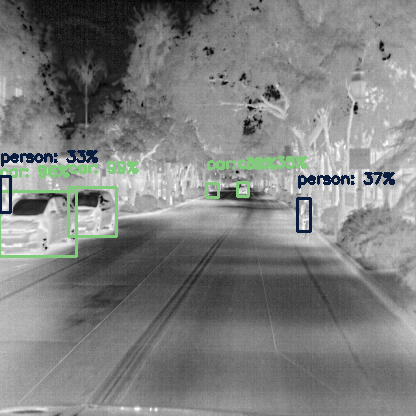

In [24]:
from PIL import Image
import tensorflow as tf

INPUT_IMAGE_URL =  "thermal/test_1842/FLIR_07098_jpeg.rf.7ed6a4f01a889b7fe45abba0ad39b75d.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


# 3. Compile with EdgeTPU

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt-get update

!sudo apt-get install edgetpu-compiler

In [ ]:
edgetpu_compiler model.tflite --num_segments=1